# Implementation 


In [8]:
####importation####
import matplotlib.pyplot as plt
import ImageProcessing.processing as pr
import numpy as np
from scipy import sparse as s

import os

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 120


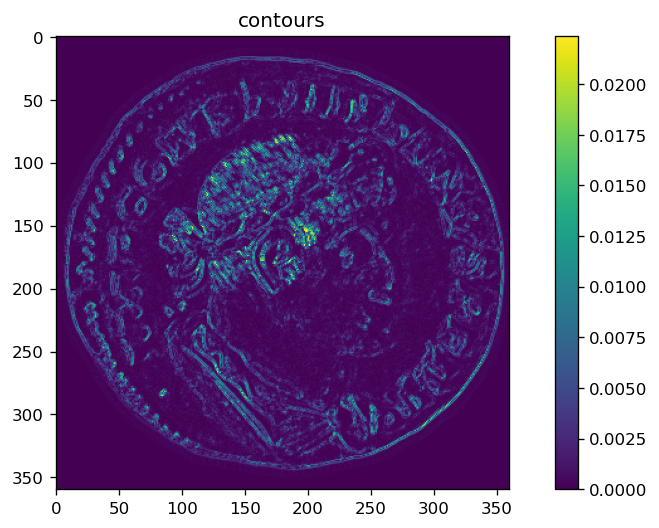

In [9]:
## Récuperation du contour ##
imgPath = imagePath = "data/19_Droit.jpg"

#Utilisation de ImageProcessing
img =pr.cropToCoin(imgPath)
contours = pr.getContour(img)
norm = np.linalg.norm(contours)
contours = contours/norm

plt.imshow(contours)
plt.colorbar()
plt.title("contours")
plt.show()



## Partie Kernel


Calculer la matrice $K^{\omega}_l$
 - Calculer $K_{l/2}$
     - Récuperer $K_{l/2}$ si existe
     - sinon recalculer
 - Calculer $ K^{\omega}_l = K^T_{l/2}W K_{l/2}$

In [10]:
def getCoordFromVect(idx:int,nbSide:int)-> np.ndarray:
    '''
    renvoie les coordonnées du pixel en fonction de 
    son indice dans un tableau 1D 
    --------------------------
    idx : index dand le tableau 1D
    nbSide : nombre de pixel sur le coté de l image carrée
    '''
    x = idx//(nbSide)
    y = idx%(nbSide)
    return np.array([x,y]) 
    
def getIdxFromArray(i:int,j:int,nbSide:int)->int:
    '''
    renvoie l'index du pixel dont les coordonnées sont 
    i et j 
    --------------------------
    i,j : coordonnées
    nbSide : nombre de pixel sur le coté de l image carrée
    '''
    return i*nbSide+ j 

def getVoisins(idx:int,nbSide:int,d:int):
    '''
    renvoie la liste des indices voisins de idx
    ----------------------
    idx: index du pixel dans un vecteur 1D
    nbSide: nombre de pixel de coté 
    d : distance du plus grand voisins '''
    
    #Coordonnées du centre
    Cx,Cy = getCoordFromVect(idx,nbSide)
    #Coordonnées de l'origine
    Ox = Cx-d
    Oy = Cy-d
    voisins = []
    for x in range(Ox,Ox+2*d+1):
        for y in range(Oy,Oy+2*d+1):

            # Valeurs dans la grille ? 
            if ((x>=0 and x<nbSide) and (y>=0 and y <nbSide)):
                voisins.append([x,y])
                
    
    ## Tranformation en idices 1D
    nb = len(voisins)
    idxVoisins = np.zeros(nb)
    for coord in range(nb):
        i,j = voisins[coord]
        idxVoisins[coord] = getIdxFromArray(i,j,nbSide)
    
    return idxVoisins

def RBF(a:np.ndarray,b:np.ndarray,l:float):
    xa,ya = a
    xb,yb = b
    d2 = (xa-xb)**2 + (ya-yb)**2
    return np.exp(-d2/(2*l**2))


def computeK(nbSide:int,l:float)-> s.lil.lil_matrix:
    '''
    Calcule et renvoie la matrice K approchée RBF
    avec un cube de longeur 6l pour chaque 
    ------------------------------
    nbSide: nombre de pixel de coté 
    l: longeur caractéristique du RBF
    '''
    d = int(np.floor(3*l))
    N = nbSide*nbSide
    M = s.lil_matrix((N,N))
    

    for i in range(N):
        voisins = getVoisins(i,nbSide,d)
        x = getCoordFromVect(i,nbSide)
        for j in voisins:
            y = getCoordFromVect(j,nbSide)
            M[i,j] = RBF(x,y,l)

    return s.csc_matrix(M)


def getK(nbSide:int,l:float)-> s.lil.lil_matrix:
    '''
    Renvoie la matrice approchée de K : 
    vérifie dans le dossier et sinon la calcule 
    et l'enregistre voir computeK 
    '''
    ## Chercher si il existe une valeur déja calculé de K 
    basepath = 'Kdata/'

    for entry in os.listdir(basepath):
        if os.path.isfile(os.path.join(basepath, entry)):
            if("%f"%l in entry):
                print("K : occurence trouvée dans la base de donnée")
                path = basepath + entry
                return s.load_npz(path)
    
    print("Calcul de K")
    K = computeK(nbSide,l)
    print("sauvegarde de K")
    s.save_npz(basepath + '/L_%f'%l, K)
    return K


def getKw(weightVec:np.ndarray,nbSide:int,l:float):
    '''
    Renvoie la matrice de covariance approchée pondéré par
    les poids du vecteur
    '''
    K = getK(nbSide,l/2)
    W = s.diags(weightVec)
    
    return K.transpose().dot(W).dot(K)

    
    
    

In [11]:
###
shape = np.shape(contours)
nbSide,b = shape

weightVec = np.ravel(contours)

l=4

Kw = getKw(weightVec,nbSide,l)

K : occurence trouvée dans la base de donnée


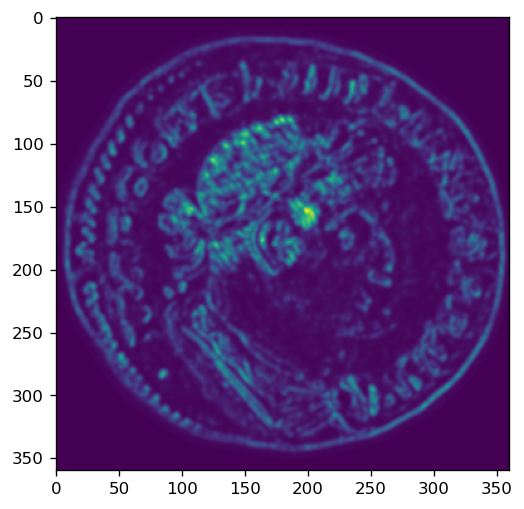

In [22]:
varVec = Kw.diagonal()
varMap = np.reshape(varVec,shape)
plt.imshow(varMap)
plt.show()

## Partie Feature 

- à partir de $K^{\omega}$ récupérer le premier point d'interêt
- récuperer le vecteur de covariance 

In [228]:
class Extractor:
    '''
    Class qui est utilisée pour récupérer les points d'interêts 
    '''
    def __init__(self,Kw:np.ndarray):
        self.featuresList = []
        self.KwBase = Kw
        self.varVectBase = Kw.diagonal()
        self.varVect = self.varVectBase
        self.psi = []
        
    def getIndexFirstFeature(self):
        idx = np.argmax(self.varVectBase)
        return idx
    
    def getIndexNextFeature(self)->int:
        '''Renvoie l'index de la prochaine feature'''
        idx = np.argmax(self.varVect)
        return idx
    
    def addFeature(self,idx:int)->None:
        '''On ajoute la feature et on fait la mise à jour de psi '''
        
        self.featuresList.append(idx)
        ## Si aucune feature on ajoute la nouvelle
        if self.psi == []:
            self.psi = self.KwBase[:,idx]
        else:
            self.psi = s.hstack([self.psi,self.KwBase[:,idx]])
        
        
    
    def updateVarVect(self):
        '''Add a feature and update varVect'''
        
        #Calcul de 
        varXsi = self.varVectBase[self.featuresList]

        
        invVarXsi = 1/varXsi
        invVarXsiDiag = s.diags(invVarXsi)
                
        
        self.varVect = s.csc_matrix(self.varVectBase) - (self.psi.dot(invVarXsiDiag).dot(self.psi.transpose())).diagonal()
        
        
    def getVarVect():
        return self.varVect
        
        
    

        

In [233]:
ext = Extractor(Kw)
ext.getIndexFirstFeature()


55639

In [234]:
C = ext.addFeature(55639)
ext.updateVarVect()
varVectUp = ext.varVect
varMapUp = np.reshape(varVectUp,shape)

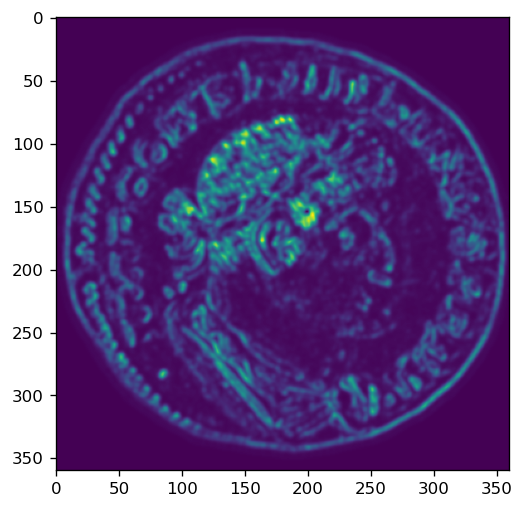

In [235]:
plt.imshow(varMapUp)

In [236]:
ext.getIndexNextFeature()

56723

In [237]:
ext.addFeature(56723)
ext.updateVarVect()
varVectUp = ext.varVect
varMapUp = np.reshape(varVectUp,shape)

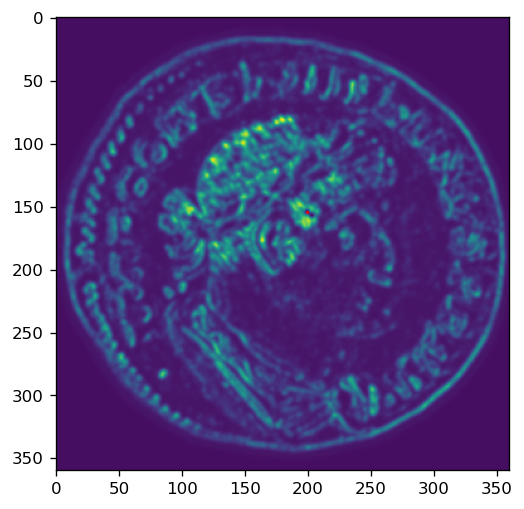

In [239]:
plt.imshow(varMapUp)
x,y = getCoordFromVect(55639,nbSide)
plt.scatter(y,x,color='r',s=0.5)